# Loading dependencies

In [1]:
import torch
import scvi
import anndata
import scanpy as sc
import numpy as np
import pandas as pd

/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install -i https://test.pypi.org/simple/ "scikit-misc==0.2.0rc1"

# Loading anndatas for WT and MUT samples. These were saved separately for memory reasons. Raw counts are saved before the integration begins

In [3]:
adata1 = anndata.read_h5ad("/mnt/g/cpa/wt_adata_merged_pre_scvi_0818.h5ad")
adata2 = anndata.read_h5ad("/mnt/g/cpa/mut_adata_merged_pre_scvi_0818.h5ad")
adata_final = adata1.concatenate(adata2)
del adata1
del adata2
adata_final


/mnt/c/Users/Darwin/AppData/Local/Programs/Microsoft VS Code/ipykernel_1324869/1935033902.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_final = adata1.concatenate(adata2)


AnnData object with n_obs × n_vars = 865644 × 31980
    obs: '0', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_malat', 'log1p_total_counts_malat', 'pct_counts_malat', 'doublet_score', 'predicted_doublet', 'size_factor', 'assignments', 'GEO', 'SRA_ID', 'assay', 'batch', 'lab_sample_id', 'sample', 'plate', 'subpool', 'SampleType', 'Tissue', 'Sex', 'Age', 'Genotype', 'subpool_type', 'Protocol', 'Chemistry', 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'Row', 'Column', 'well_type', 'Mouse_Tissue_ID', 'Multiplexed_sample1', 'Multiplexed_sample2', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'ZT', 'Dissector', 'Tissue_weight_mg', 'Notes', 'B6J_klue_counts', 'NODJ_klue_counts', 'AJ_klue_counts', 'PWKJ_

In [4]:

np.random.seed(42)
df = pd.read_excel("/mnt/g/cpa/pituitary_atlas.xlsx")
pituitary_atlas = df.copy()
#only keep sn or sc for now
df = df[df['Modality'].isin(['sc','sn','multi_rna'])]
df = df[df['species'].isin(['mouse'])]
df.reset_index(drop=True, inplace=True)
adata_final.obs = pd.merge(adata_final.obs, df, left_on='SRA_ID', right_on='SRA_ID')
#adata_final.raw = adata_final # keep full dimension
adata_final.obs.index = adata_final.obs.index.astype(str)
sc.pp.filter_genes(adata_final, min_cells=100)
adata_final.layers['counts']=adata_final.X.copy()
adata_final #865644 × 28401 last time

AnnData object with n_obs × n_vars = 865644 × 28401
    obs: '0', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_malat', 'log1p_total_counts_malat', 'pct_counts_malat', 'doublet_score', 'predicted_doublet', 'size_factor', 'assignments', 'GEO_x', 'SRA_ID', 'assay', 'batch', 'lab_sample_id', 'sample', 'plate', 'subpool', 'SampleType', 'Tissue', 'Sex_x', 'Age_x', 'Genotype', 'subpool_type', 'Protocol', 'Chemistry', 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'Row', 'Column', 'well_type', 'Mouse_Tissue_ID', 'Multiplexed_sample1', 'Multiplexed_sample2', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'ZT', 'Dissector', 'Tissue_weight_mg', 'Notes', 'B6J_klue_counts', 'NODJ_klue_counts', 'AJ_klue_counts', 

# Adding mt, malat, ribo pct to each cell. This will be taken into account by the scVI model

In [5]:
adata_final.var = adata_final.var.loc[:, ~adata_final.var.columns.str.match(r'(n_cells_by_counts|malat|mean_counts|log1p_mean_counts|pct_dropout_by_counts|total_counts|log1p_total_counts)-\d+')]


In [6]:
#add info on pct_mt pct_ribo and pct_malat
def add_mt_ribo_malat(adata):
  mt_tag="mt-"
  ribo_tag=("Rps","Rpl")
  malat_tag="Malat1"
  adata.var["mt"] = adata.var_names.str.startswith(mt_tag)
  adata.var["ribo"] = adata.var_names.str.startswith(ribo_tag)
  adata.var["malat"] = adata.var_names.str.startswith(malat_tag)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "malat"], inplace=True, percent_top=[20], log1p=True)

add_mt_ribo_malat(adata_final)
#print all cols of a df
pd.set_option('display.max_columns', None)
adata_final.obs.head(5)

,0,n_genes,n_counts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_malat,log1p_total_counts_malat,pct_counts_malat,doublet_score,predicted_doublet,size_factor,assignments,GEO_x,SRA_ID,assay,batch,lab_sample_id,sample,plate,subpool,SampleType,Tissue,Sex_x,Age_x,Genotype,subpool_type,Protocol,Chemistry,bc,bc1_sequence,bc2_sequence,bc3_sequence,bc1_well,bc2_well,bc3_well,Row,Column,well_type,Mouse_Tissue_ID,Multiplexed_sample1,Multiplexed_sample2,DOB,Age_days,Body_weight_g,Estrus_cycle,Dissection_date,Dissection_time,ZT,Dissector,Tissue_weight_mg,Notes,B6J_klue_counts,NODJ_klue_counts,AJ_klue_counts,PWKJ_klue_counts,129S1J_klue_counts,CASTJ_klue_counts,WSBJ_klue_counts,NZOJ_klue_counts,n_genes_by_counts_raw,total_counts_raw,total_counts_mt_raw,pct_counts_mt_raw,n_genes_by_counts_cb,total_counts_cb,total_counts_mt_cb,pct_counts_mt_cb,background_fraction,cell_probability,cell_size,droplet_efficiency,leiden,leiden_R,general_celltype,general_CL_ID,celltype,CL_ID,subtype,GEO_y,Name,Conditions,Normal,Background,Sorted,Author,DOI,Age_y,Sex_numeric,Sex_y,Comp_sex,Estrous_stage,Age_numeric,Single_pool,10X version,Modality,published,species,Sample_wrong_sex,Sample_missing_sex,Sample_wrong_barcode_kit,Sample_switched_up,Sample_kept_for_analysis,Study_Seurat_version,Study_CR_version,Study_minimum_n,Study_minimum_group,pseudoaligned,passed_qc,filtering_junk,median_cellassign_prob,most_recent_workflow,n_cells,processed_atac,passed_qc_tcc,tcc_pseudobulked,Core,Notes 1,Notes 2,pct_counts_in_top_20_genes
0,AAACCTGAGGATGTAT,2253,5991.0,2245,7.716906,5419.0,8.597851,147.0,4.997212,2.712678,471.0,6.156979,8.691641,59.0,4.094345,1.088762,0.020781,False,0.772444,Corticotrophs,GSM4594333,SRX8489818,sc,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSM4594333,M-Pituitary,normal,1,C57BL/6,0,Ruf-Zamojski et al. (2021),10.1038/s41467-021-22859-w,10-12 weeks,1.0,male,1.0,NaN,77.0,single,10XV2,sc,1.0,mouse,NaN,NaN,NaN,NaN,NaN,v.3.1.1,v3.0.2,2,female_sc,1.0,1.0,1.0,1.0,v_0.01,1278.0,0.0,1.0,v_0.01,1.0,NaN,NaN,14.984314
1,AAACCTGAGTACCGGA,1376,3736.0,1330,7.193686,3106.0,8.041413,69.0,4.248495,2.221507,101.0,4.624973,3.251771,30.0,3.433987,0.965873,0.016743,False,0.442659,Somatotrophs,GSM4594333,SRX8489818,sc,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSM4594333,M-Pituitary,normal,1,C57BL/6,0,Ruf-Zamojski et al. (2021),10.1038/s41467-021-22859-w,10-12 weeks,1.0,male,1.0,NaN,77.0,single,10XV2,sc,1.0,mouse,NaN,NaN,NaN,NaN,NaN,v.3.1.1,v3.0.2,2,female_sc,1.0,1.0,1.0,1.0,v_0.01,1278.0,0.0,1.0,v_0.01,1.0,NaN,NaN,36.606568
2,AAACGGGAGTACGACG,2771,12612.0,2752,7.920447,10795.0,9.286931,171.0,5.147494,1.584067,631.0,6.448889,5.845299,0.0,0.000000,0.000000,0.020781,False,1.538475,Thyrotrophs,GSM4594333,SRX8489818,sc,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSM4594333,M-Pituitary,normal,1,C57BL/6,0,Ruf-Zamojski et al. (2021),10.1038/s41467-021-22859-w,10-12 weeks,1.0,male,1.0,NaN,77.0,single,10XV2,sc,1.0,mouse,NaN,NaN,NaN,NaN,NaN,v.3.1.1,v3.0.2,2,female_sc,1.0,1.0,1.0,1.0,v_0.01,1278.0,0.0,1.0,v_0.01,1.0,NaN,NaN,42.176934
3,AAACGGGCAAATACAG,3853,27815.0,3823,8.249052,22963.0,10.041683,11.0,2.484907,0.047903,1000.0,6.908755,4.354832,35.0,3.583519,0.152419,0.088000,False,3.272911,Somatotrophs,GSM4594333,SRX8489818,sc,0

In [7]:
adata_final.obs["Comp_sex"] = adata_final.obs["Comp_sex"].astype(str)


# Adjusting the modality to separate between 10x and Parse single-nucleus data

In [8]:
adata_final.obs["scvi_modality"] = adata_final.obs["Modality"]

#where Modality is sn and 10X version is PARSE_WT_MegaV2, modify scvi_modality to parse_sn
condition = (
    (adata_final.obs["Modality"] == "sn") &
    (adata_final.obs["10X version"] == "PARSE_WT_MegaV2")
)

adata_final.obs.loc[condition, "scvi_modality"] = "parse_sn"

In [9]:
# keep 5k genes
diversity_tracker = []

for sra_id in adata_final.obs['SRA_ID'].unique():
    subset_adata = adata_final[adata_final.obs['SRA_ID'] == sra_id]
    cell_type_counts = subset_adata.obs['assignments'].value_counts()
    
    # Count how many cell types have at least 200 cells
    diverse_cell_types = (cell_type_counts >= 200).sum()
    diversity_tracker.append({'SRA_ID': sra_id, 'Diverse_Cell_Types': diverse_cell_types})

diversity_df = pd.DataFrame(diversity_tracker)

# Step 3: Choose the top 5 most diverse datasets
top_5_diverse_sra_ids = diversity_df.sort_values(by='Diverse_Cell_Types', ascending=False).head(5)['SRA_ID'].tolist()

# Step 4: Filter adata to keep only the top 5 diverse datasets
adata_filtered_by_diversity = adata_final[adata_final.obs['SRA_ID'].isin(top_5_diverse_sra_ids)].copy() # Use .copy() to avoid SettingWithCopyWarning

# Step 5: Identify highly variable genes on the filtered adata
# It's crucial to re-run highly_variable_genes on the subsetted data
sc.pp.highly_variable_genes(adata_filtered_by_diversity, n_top_genes=5000, batch_key="SRA_ID", flavor='seurat_v3')


# Step 6: Get the names of the highly variable genes
highly_var_genes = adata_filtered_by_diversity.var_names[adata_filtered_by_diversity.var['highly_variable']]

print(f"Top 5 most diverse SRA_IDs: {top_5_diverse_sra_ids}")
print(f"Number of highly variable genes found: {len(highly_var_genes)}")

Top 5 most diverse SRA_IDs: ['SRX5292053', 'SRX22219346', 'SRX25532498', 'SRX25736223', 'ERX7593483']
Number of highly variable genes found: 5000


In [10]:
adata_final = adata_final[:,highly_var_genes].copy()

# setting up the scVI model

In [11]:
scvi.model.SCVI.setup_anndata(adata_final, batch_key="SRA_ID",categorical_covariate_keys=["scvi_modality","Comp_sex"], continuous_covariate_keys = ["Age_numeric","pct_counts_mt", 'pct_counts_ribo','pct_counts_malat'])
vae = scvi.model.SCVI(adata_final, n_layers=2, n_latent=30, gene_likelihood="nb")


In [12]:
vae.train(max_epochs=100,early_stopping_patience=20,early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.
/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_

Epoch 100/100: 100%|██████████| 100/100 [2:16:45<00:00, 81.94s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.31e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [2:16:45<00:00, 82.05s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.31e+3]


In [13]:
vae_dir = "/mnt/g/cpa/vae_0828/"
vae.save(dir_path=vae_dir)
vae = scvi.model.SCVI.load(vae_dir, adata_final)

INFO     File /mnt/g/cpa/vae_0828/model.pt already downloaded                                                      


# Plotting metrics to visualise convergence of the model

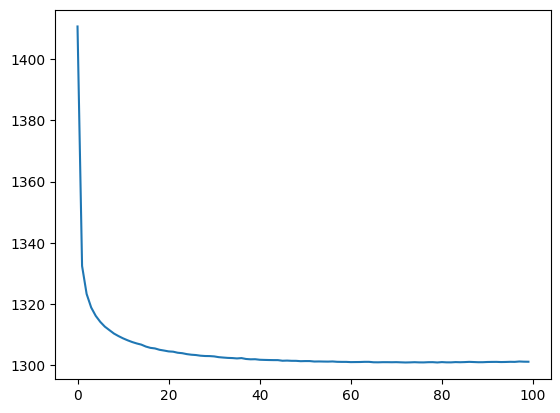

In [14]:
#plot convergence
import matplotlib.pyplot as plt
plt.plot(vae.history["reconstruction_loss_train"], label="train")

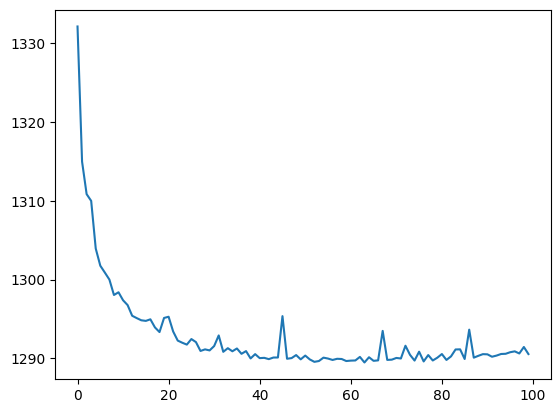

In [15]:
#plot convergence
import matplotlib.pyplot as plt
plt.plot(vae.history["reconstruction_loss_validation"], label="validation")

# Get latent representation and proceed to obtaining neighbours and clusters

In [16]:
adata_final.obsm["X_scVI"] = vae.get_latent_representation()



In [17]:
sc.pp.neighbors(adata_final, use_rep="X_scVI")


In [18]:
sc.tl.leiden(adata_final, resolution=0.5, key_added="leiden_scVI", random_state=42,flavor="igraph")

# Saving resulting objects as checkpoint

In [19]:
df_obs =  adata_final.obs
df_var = adata_final.var

adata_final.obs = df_obs
adata_final.var = df_var

In [20]:
adata_final.obs.index = adata_final.obs["0"].values

In [21]:

#save adata
adata_final.obs.index = adata_final.obs["0"].values
#adata_final.var.index = adata_final.var["0"].values
#adata_final.var.index = [str(i) for i in adata_final.var.index.values]
adata_final.var["feature_types"] = "mrna"
#adata_final.obs.index = [str(i) for i in adata_final.obs.index.values]


In [22]:
adata_final.obs = adata_final.obs.astype(str)
adata_final.var = adata_final.var.astype(str)

/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['AAACCTGAGGATGTAT', 'AAACCTGAGTACCGGA', 'AAACGGGAGTACGACG', 'AAACGGGCAAATACAG', 'AAACGGGCATCGGTTA']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [23]:
import sys
sys.getsizeof(adata_final)

17404463809

In [24]:
adata_final

AnnData object with n_obs × n_vars = 865644 × 5000
    obs: '0', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_malat', 'log1p_total_counts_malat', 'pct_counts_malat', 'doublet_score', 'predicted_doublet', 'size_factor', 'assignments', 'GEO_x', 'SRA_ID', 'assay', 'batch', 'lab_sample_id', 'sample', 'plate', 'subpool', 'SampleType', 'Tissue', 'Sex_x', 'Age_x', 'Genotype', 'subpool_type', 'Protocol', 'Chemistry', 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'Row', 'Column', 'well_type', 'Mouse_Tissue_ID', 'Multiplexed_sample1', 'Multiplexed_sample2', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'ZT', 'Dissector', 'Tissue_weight_mg', 'Notes', 'B6J_klue_counts', 'NODJ_klue_counts', 'AJ_klue_counts', '

In [25]:

adata_final.write("/mnt/g/cpa/scvi_all_cells_0828.h5ad",compression="gzip")


In [ ]:
df_obs.to_excel("/mnt/g/cpa/df_obs_0828.xlsx")
df_var.to_excel("/mnt/g/cpa/df_var_0828.xlsx")

# Loading back the created object

In [2]:
adata_final = anndata.read_h5ad("/mnt/g/cpa/scvi_all_cells_0828.h5ad")

/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:

df_obs = pd.read_excel("/mnt/g/cpa/df_obs_0828.xlsx")
df_var = pd.read_excel("/mnt/g/cpa/df_var_0828.xlsx")
adata_final.obs = df_obs
adata_final.var = df_var



In [4]:
adata_final.obs["Comp_sex"] = adata_final.obs["Comp_sex"].astype(str)
vae = scvi.model.SCVI.load("/mnt/g/cpa/vae_0828", adata_final)

INFO     File /mnt/g/cpa/vae_0828/model.pt already downloaded                                                      


/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/scvi/model/base/_base_model.py:830: UserWarning: `var_names` for the loaded `model` does not match those used to train the model. For valid results, the former should match the latter.
  _validate_var_names(adata, var_names)


# Plotting umap

In [5]:
sc.tl.umap(adata_final, min_dist=0.3)

In [6]:
adata_final.obs["leiden_scVI"] = [str(i) for i in adata_final.obs["leiden_scVI"].values]

In [7]:
adata_final[adata_final.obs["Comp_sex"]=="nan"].obs["SRA_ID"].value_counts()

Series([], Name: count, dtype: int64)

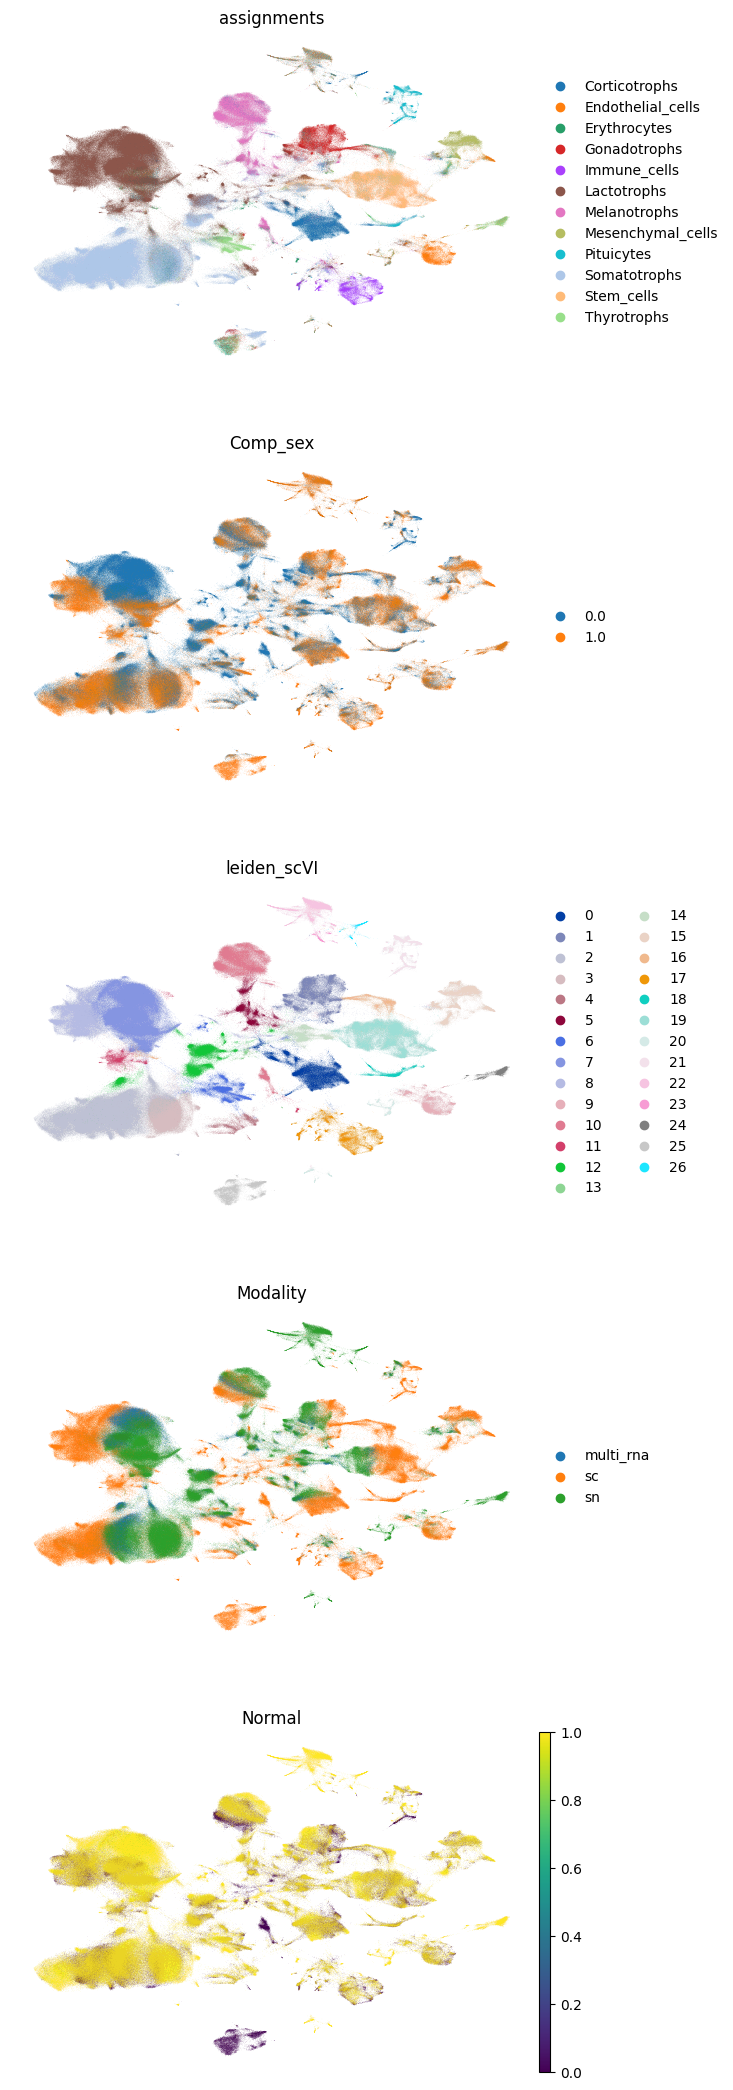

In [8]:
sc.pl.umap(
    adata_final,
    color=["assignments","Comp_sex","leiden_scVI","Modality","Normal"],
    frameon=False,
    ncols=1,
    layer="SCVI_normalised",
)

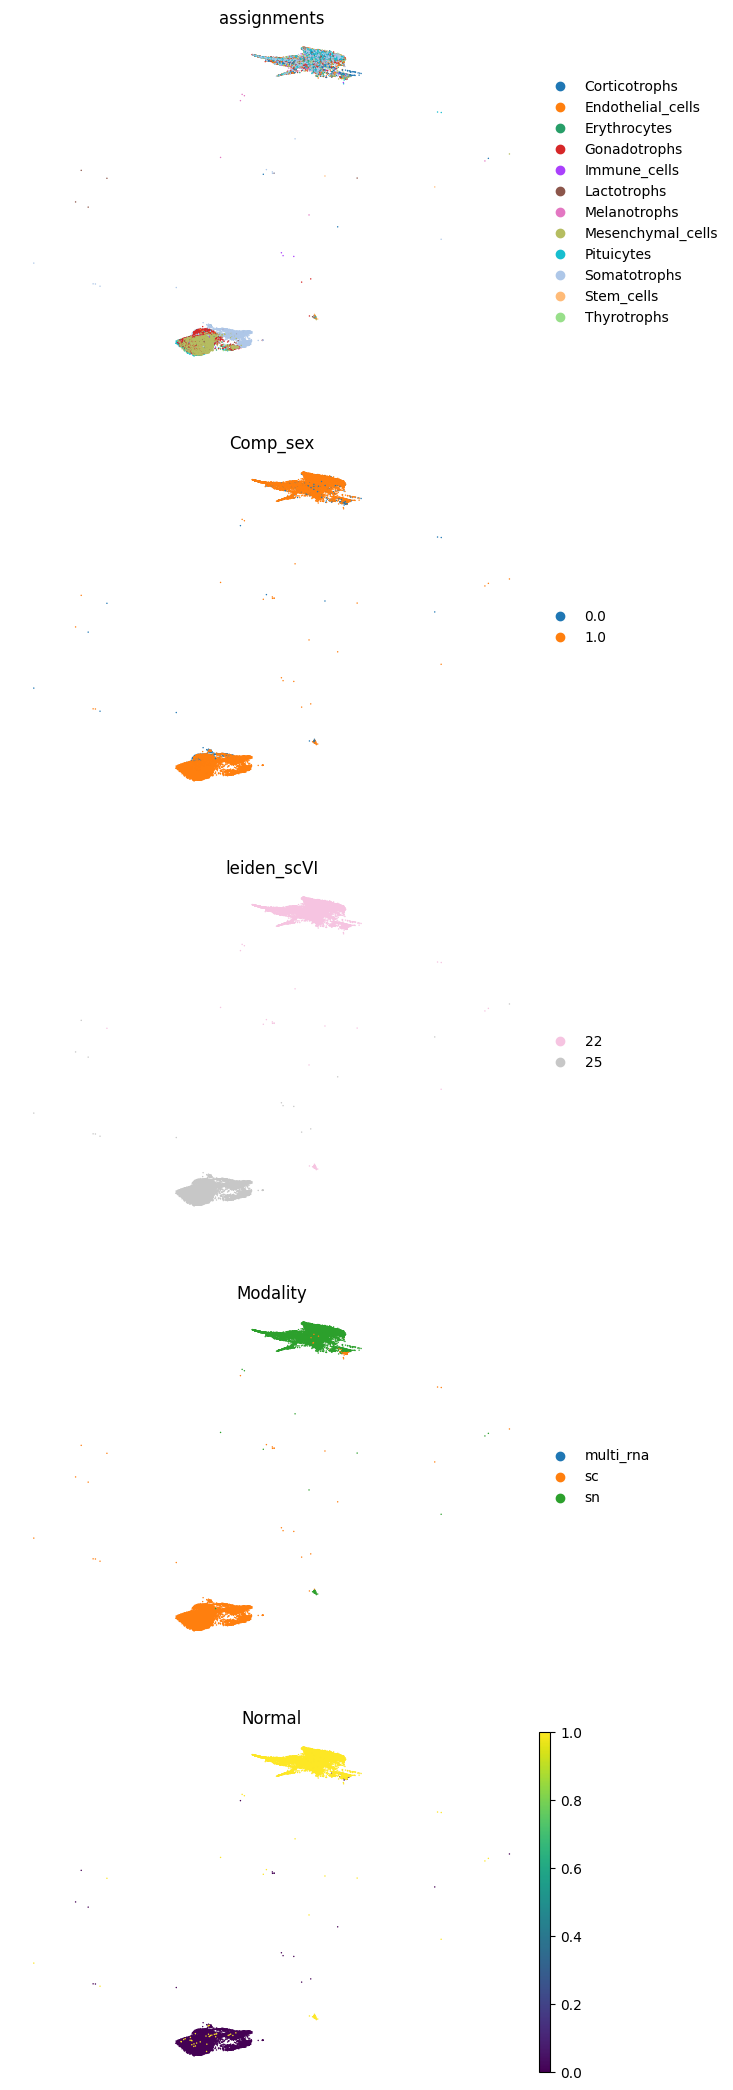

In [9]:
sc.pl.umap(
    adata_final[adata_final.obs["leiden_scVI"].isin(["25","22"])],
    color=["assignments","Comp_sex","leiden_scVI","Modality","Normal"],
    frameon=False,
    ncols=1,
    layer="SCVI_normalised",
)

In [10]:
sc.pp.neighbors(adata_final, use_rep="X_scVI", n_neighbors=100)

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm

def optimize_cell_type_assignment(object, rep="X_scVI", n_neighbors=100, threshold=0.6666):
    """
    Optimized function for cell type assignment using neighbor voting.
    If the majority vote is less than the threshold (default 50%), leave the cell type unchanged.
   
    Args:
        object: AnnData object
        rep: String representation to use for neighbor computation
        n_neighbors: Number of neighbors to consider
        threshold: Minimum proportion of neighbors required for a vote to update the cell type
    """

    if 'new_cell_type' not in object.obs.columns:
        cell_types = object.obs['assignments'].values
    else:
        cell_types = object.obs['new_cell_type'].values


    # Compute neighbors if not already present
    if 'new_cell_type' not in object.obs.columns:
        object.obs['new_cell_type'] = object.obs['assignments'].copy()
   
    # Get connectivity matrix in CSR format for efficient row slicing
    connectivity_matrix = object.obsp['connectivities'].tocsr()


    unknown_mask = cell_types != "unknown"
    unknown_indices = np.where(unknown_mask)[0]
   
    # Process unknown cells in batches for memory efficiency
    batch_size = 1000
    for batch_start in tqdm(range(0, len(unknown_indices), batch_size), desc="Processing batches"):
        batch_indices = unknown_indices[batch_start:batch_start + batch_size]
       
        # Get neighbor indices for current batch
        neighbor_indices = [
            connectivity_matrix[idx].indices[:n_neighbors]
            for idx in batch_indices
        ]
       
        # Get neighbor types for all cells in batch at once
        neighbor_types = [
            cell_types[indices][cell_types[indices] != "unknown"]
            for indices in neighbor_indices
        ]
       
        # Calculate majority vote for each cell
        majority_types = []
        for idx, types in zip(batch_indices, neighbor_types):
            if len(types) > 0:
                # Use np.unique to find the most common type
                unique, counts = np.unique(types, return_counts=True)
                majority_type = unique[np.argmax(counts)]
                majority_count = counts[np.argmax(counts)]
                majority_proportion = majority_count / len(types)

                # Only update the cell type if the majority vote is at least the threshold (e.g., 60%)
                if majority_proportion >= threshold:
                    majority_types.append(majority_type)
                else:
                    # If the majority proportion is less than the threshold, keep the current cell's type
                    majority_types.append(cell_types[idx])
            else:
                # If no neighbors have a type, keep the current cell's type
                majority_types.append(cell_types[idx])
        
        # Update the cell type for the current batch of cells
        object.obs['new_cell_type'].iloc[batch_indices] = majority_types
    
    # Calculate the number of differences between assignments and new_cell_type
    differences = (object.obs['assignments'] != object.obs['new_cell_type']).sum()
    
    # Print the number of differences
    print(f"Number of differences between assignments and new_cell_type: {differences}")
    

    return object

adata_final.obs['new_cell_type'] = adata_final.obs['assignments'] 
unknown_cells = optimize_cell_type_assignment(adata_final)
unknown_cells = optimize_cell_type_assignment(adata_final)
unknown_cells = optimize_cell_type_assignment(adata_final)

Processing batches:   0%|          | 0/866 [00:00<?, ?it/s]/tmp/ipykernel_4152/2321797853.py:73: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  object.obs['new_cell_type'].iloc[batch_indices] = majority_types
Processing batches: 100%|████████

Number of differences between assignments and new_cell_type: 41115


Processing batches: 100%|██████████| 866/866 [00:53<00:00, 16.24it/s]


Number of differences between assignments and new_cell_type: 49603


Processing batches: 100%|██████████| 866/866 [00:54<00:00, 16.02it/s]

Number of differences between assignments and new_cell_type: 52415


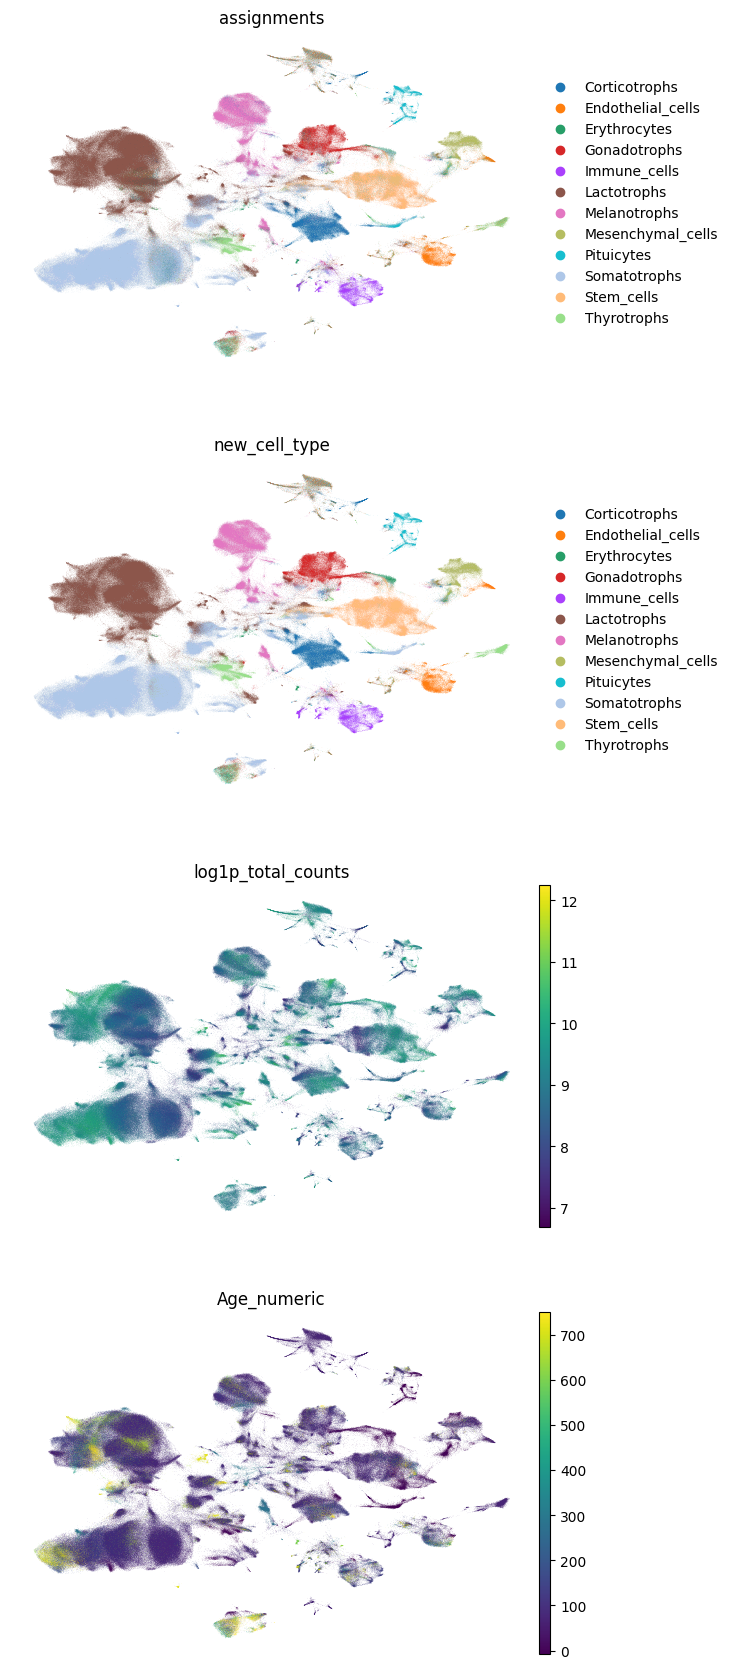

In [12]:
sc.pl.umap(
    adata_final,
    color=["assignments","new_cell_type","log1p_total_counts","Age_numeric"],
    frameon=False,
    ncols=1,
    layer="SCVI_normalised",
)


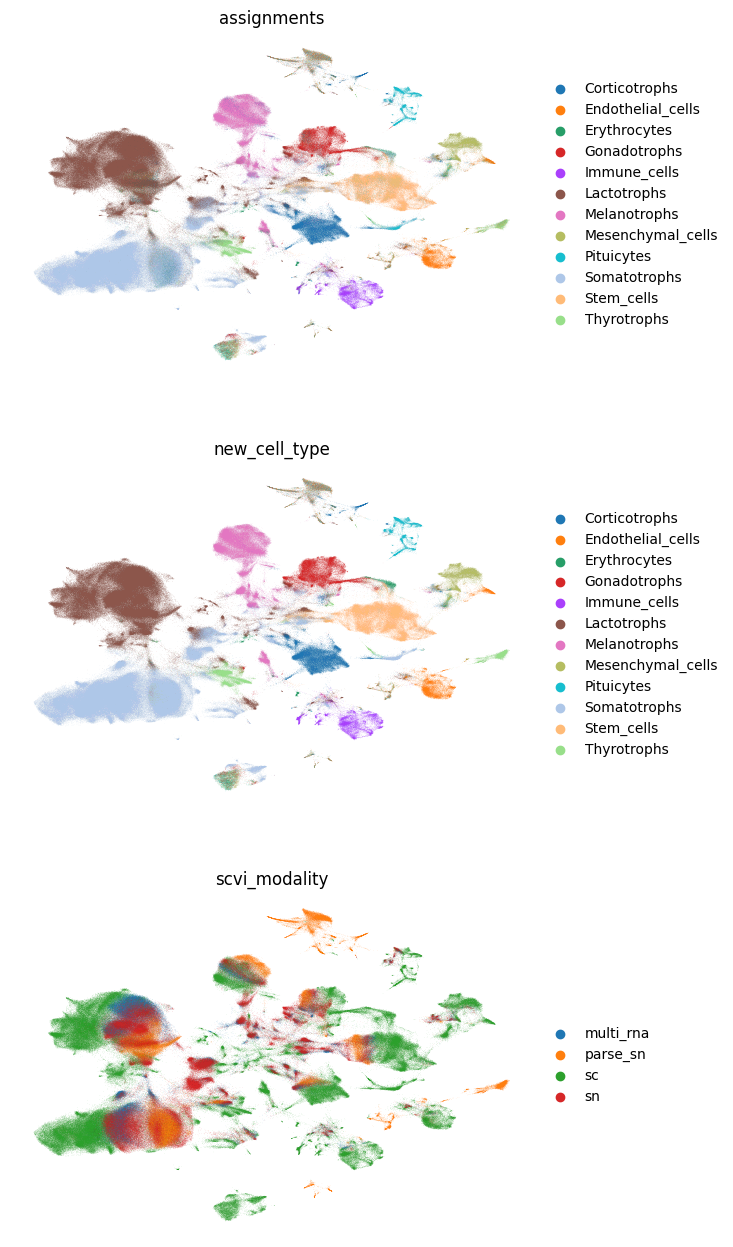

In [13]:
sc.pl.umap(
    adata_final,
    color=["assignments","new_cell_type","scvi_modality"],
    frameon=False,
    ncols=1,
    layer="SCVI_normalised",
)

# Removing noisy mixed clusters

In [14]:
#adata_final = adata_final[~adata_final.obs["leiden_scVI"].isin(["3","16"])]

In [15]:
adata_final[adata_final.obs["leiden_scVI"].isin(["25","22"])].obs["SRA_ID"].value_counts()[:15]

SRA_ID
ERX13202613          2683
ERX4978538           2234
ERX13202614          1987
ERX4978541           1798
ERX4978542           1579
067_NODJ_10M_01      1439
044_129S1J_10F_01    1224
ERX4978543           1151
045_129S1J_10M_01    1020
026_AJ_10F_01         936
070_NODJ_10F_01       853
018_B6J_10F_01        820
025_B6J_10M_01        807
024_B6J_10F_01        785
037_129S1J_10M_01     705
Name: count, dtype: int64

In [16]:
adata_final[adata_final.obs["leiden_scVI"].isin(["25","22"])].obs["SRA_ID"].value_counts()[:15]

SRA_ID
ERX13202613          2683
ERX4978538           2234
ERX13202614          1987
ERX4978541           1798
ERX4978542           1579
067_NODJ_10M_01      1439
044_129S1J_10F_01    1224
ERX4978543           1151
045_129S1J_10M_01    1020
026_AJ_10F_01         936
070_NODJ_10F_01       853
018_B6J_10F_01        820
025_B6J_10M_01        807
024_B6J_10F_01        785
037_129S1J_10M_01     705
Name: count, dtype: int64

In [23]:
adata_final.obs.columns

Index(['Unnamed: 0', '0', 'n_genes', 'n_counts', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'total_counts_mt', 'log1p_total_counts_mt',
       ...
       'tcc_pseudobulked', 'Core', 'Notes 1', 'Notes 2',
       'pct_counts_in_top_20_genes', 'scvi_modality', '_scvi_batch',
       '_scvi_labels', 'leiden_scVI', 'new_cell_type'],
      dtype='object', length=133)

In [25]:
#save values of .obs, specifically  SRA_ID, "assignments","GEO,"leiden_scVI"
output_path = '/mnt/g/cpa/assignments_leiden_obs_0828.csv'
#adata_final.obs[["0","GEO","SRA_ID","assignments","leiden_scVI","new_cell_type"]]
adata_final.obs.to_csv(output_path, index=False)

In [26]:
adata_final.obs = pd.read_csv('/mnt/g/cpa/assignments_leiden_obs_0828.csv')

/tmp/ipykernel_4152/4123050966.py:1: DtypeWarning: Columns (0,1,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,47,48,49,50,53,54,55,56,57,59,81,82,83,84,85,86,88,94,95,99,111,112,123,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  adata_final.obs = pd.read_csv('/mnt/g/cpa/assignments_leiden_obs_0828.csv')


In [27]:
adata_final.obs["Comp_sex"] = (
    adata_final.obs["Comp_sex"]
    .astype(str)  # convert floats to string
    .astype("category")  # then to categorical
)


# Continuing with scANVI - improves embedding for visualisations

In [28]:
import gc
gc.collect()

Exception ignored in: <function ZipFile.__del__ at 0x7f1f5b350fe0>
Traceback (most recent call last):
  File "/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/zipfile.py", line 1895, in __del__
    self.close()
  File "/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/zipfile.py", line 1912, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <_cython_3_0_11.generator object at 0x7f1ae4a8d3f0>
Traceback (most recent call last):
  File "openpyxl/worksheet/_writer.py", line 288, in get_stream
  File "src/lxml/serializer.pxi", line 1263, in lxml.etree.xmlfile.__exit__
  File "src/lxml/serializer.pxi", line 1603, in lxml.etree._IncrementalFileWriter._close
  File "src/lxml/serializer.pxi", line 1609, in lxml.etree._IncrementalFileWriter._handle_error
  File "src/lxml/serializer.pxi", line 198, in lxml.etree._raiseSerialisationError
lxml.etree.SerialisationError: IO_WRITE


115133248

In [29]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_final,
    labels_key="new_cell_type",
    unlabeled_category="Unknown",
)

scanvi_model.to_device("cuda:0")

In [30]:
scanvi_model.train(max_epochs=50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Epoch 50/50: 100%|██████████| 50/50 [2:35:04<00:00, 180.87s/it, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.3e+3]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [2:35:04<00:00, 186.10s/it, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.3e+3]


In [32]:
scanvi_dir = "/mnt/g/cpa/scanvi_0828/"
scanvi_model.save(dir_path=scanvi_dir)
scanvi_model = scvi.model.SCANVI.load(scanvi_dir , adata_final)

INFO     File /mnt/g/cpa/scanvi_0828/model.pt already downloaded                                                   


In [33]:
SCANVI_LATENT_KEY = "X_scANVI"
adata_final.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata_final)

In [34]:
import gc
gc.collect()

Exception ignored in: <function ZipFile.__del__ at 0x7f1f5b350fe0>
Traceback (most recent call last):
  File "/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/zipfile.py", line 1895, in __del__
    self.close()
  File "/home/darwin/miniconda3/envs/bencenv_wsl/lib/python3.11/zipfile.py", line 1912, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <_cython_3_0_11.generator object at 0x7f12074bf5b0>
Traceback (most recent call last):
  File "openpyxl/worksheet/_writer.py", line 288, in get_stream
  File "src/lxml/serializer.pxi", line 1263, in lxml.etree.xmlfile.__exit__
  File "src/lxml/serializer.pxi", line 1603, in lxml.etree._IncrementalFileWriter._close
  File "src/lxml/serializer.pxi", line 1609, in lxml.etree._IncrementalFileWriter._handle_error
  File "src/lxml/serializer.pxi", line 198, in lxml.etree._raiseSerialisationError
lxml.etree.SerialisationError: IO_WRITE


4332443

In [35]:
sc.pp.neighbors(adata_final, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata_final)

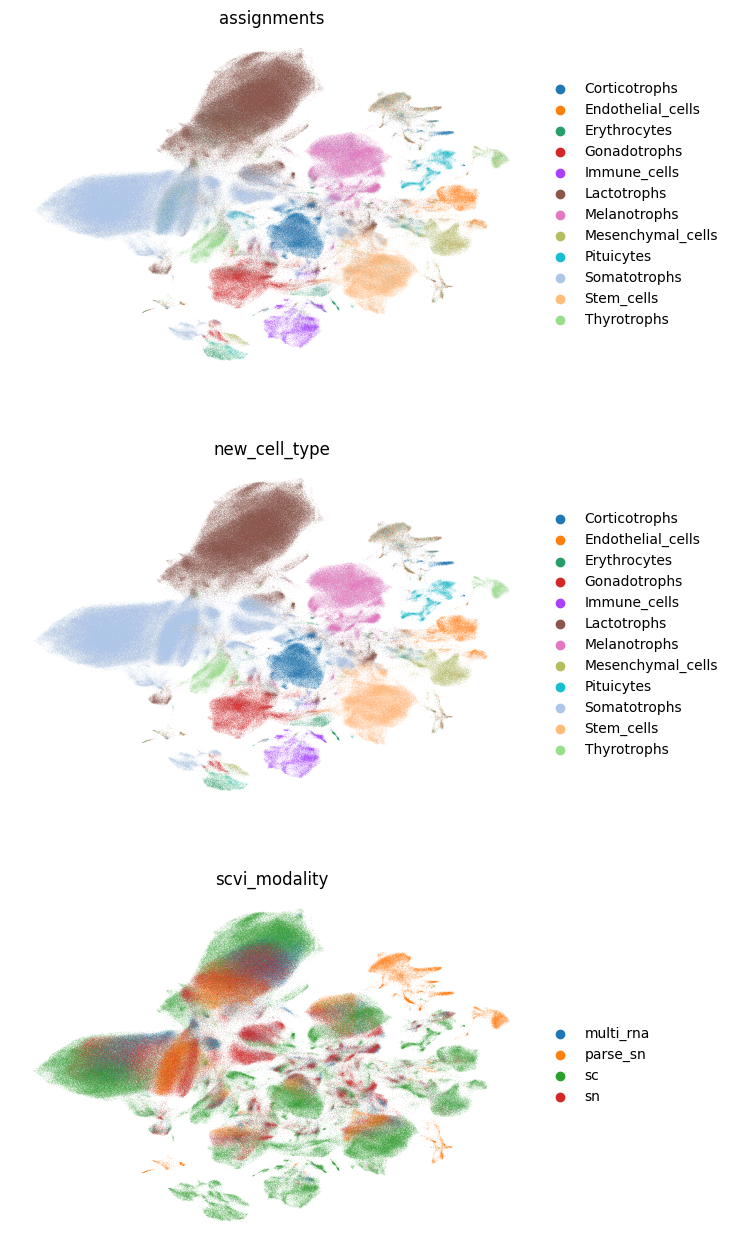

In [36]:
sc.pl.umap(
    adata_final,
    color=["assignments","new_cell_type","scvi_modality"],
    frameon=False,
    ncols=1,
    layer="SCVI_normalised",
)

In [37]:
import pandas as pd

# Convert to DataFrame
umap_df = pd.DataFrame(adata_final.obsm["X_umap"], columns=["UMAP1", "UMAP2"])

# Save as CSV
umap_df.to_csv("/mnt/g/cpa/umap_coordinates_0828.csv", index=False)


In [38]:
adata_final.obs = adata_final.obs.astype(str)
adata_final.var = adata_final.var.astype(str)

In [39]:
# Add UMAP coordinates to .obs
adata_final.obs["UMAP1"] = adata_final.obsm["X_umap"][:, 0]
adata_final.obs["UMAP2"] = adata_final.obsm["X_umap"][:, 1]

# Remove .uns, .obsm, and .obsp
adata_final.uns = {}
adata_final.obsm = {}
adata_final.obsp = {}


In [40]:
adata_final

AnnData object with n_obs × n_vars = 865644 × 5000
    obs: 'Unnamed: 0', '0', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_malat', 'log1p_total_counts_malat', 'pct_counts_malat', 'doublet_score', 'predicted_doublet', 'size_factor', 'assignments', 'GEO_x', 'SRA_ID', 'assay', 'batch', 'lab_sample_id', 'sample', 'plate', 'subpool', 'SampleType', 'Tissue', 'Sex_x', 'Age_x', 'Genotype', 'subpool_type', 'Protocol', 'Chemistry', 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'Row', 'Column', 'well_type', 'Mouse_Tissue_ID', 'Multiplexed_sample1', 'Multiplexed_sample2', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'ZT', 'Dissector', 'Tissue_weight_mg', 'Notes', 'B6J_klue_counts', 'NODJ_klue_counts', 'AJ_k

In [41]:
adata_final.write("/mnt/g/cpa/scanvi_all_cells_0828.h5ad",compression="gzip")